# Testing LOSD
### Bevölkerung nach Stadtkreis, seit 1993

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Stadtkreis und Jahr, seit 1993.

https://data.integ.stadt-zuerich.ch/dataset/bev324od3242

Datum: 12.02.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3242_losd_bev_bestand_jahr_kreis_od3242.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Setze einige Pfadvariabeln

**BITTE HIER ANPASSEN**

In [6]:
package_name = "bev324od3242"
package_name = package_name.upper()
print(package_name)

BEV324OD3242


In [7]:
dataset_name = "bev324od3242.csv"

**Statische Pfade CKAN-URLs**

In [8]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"
ld_integ_url ="https://ld.integ.stadt-zuerich.ch/statistics/view/"

In [9]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"
ld_prod_url ="https://ld.stadt-zuerich.ch/statistics/view/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [10]:
from IPython.display import Markdown as md

In [11]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name.lower()))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev324od3242 

In [12]:
md(" **2. Dataset auf INTEG-LD:** Link {} ".format(ld_integ_url+package_name.upper()))

 **2. Dataset auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3242 

In [13]:
md(" **3. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name.lower()))

 **3. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev324od3242 

In [14]:
md(" **4. Dataset auf PROD-LD:** Link {} ".format(ld_prod_url+package_name.upper()))

 **4. Dataset auf PROD-LD:** Link https://ld.stadt-zuerich.ch/statistics/view/BEV324OD3242 

### Setze ein paar Zeitvariabeln
Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe [Link](https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime)
Zuerst die Zeitvariabeln als Strings

In [15]:
now = datetime.date.today()
year_today = now.strftime("%Y")

Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [16]:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Importiere den Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [17]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

int - web


In [18]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            #fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = ckan_prod_url+package_name+'/download/'+dataset_name
        fp = ld_prod_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        #fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = ckan_integ_url+package_name+'/download/'+dataset_name
        fp = ld_integ_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)


fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3242/observation?format=csv


In [19]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['ZEIT_lang']
        ,low_memory=False)
    print("web")

data2betested.dtypes
#data2betested.sort_values("ZEIT_lang", ascending=True)

web


ZEIT_lang     object
ZEIT_code     object
RAUM_lang     object
RAUM_code     object
BEW          float64
dtype: object

In [20]:
data2betested.sort_values("ZEIT_lang", ascending=False).head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW
948,2023-12-31,Z31122023,Kreis 5 (ab 1915),R00800,15874
1294,2023-12-31,Z31122023,Kreis 7 (ab 1934),R01300,39647


Berechne weitere Attribute falls notwendig

`ACHTUNG`!

In Pandas kann `datetime` Daten ab dem Jahr **1677** speichern. Das liegt daran, dass Pandas datetime64[ns] auf der Basis von NumPy verwendet, das wiederum den Datentyp datetime64 bereitstellt, der auf dem Standard des Proleptischen Gregorianischen Kalenders basiert. Dieser Kalender geht bis zum Jahr 1677 zurück.

Alternative: Abfangen des Problems mit Funktion:

-----------------------------------------------

In [21]:
def convert_to_datetime(date_str):
    try:
        date = pd.to_datetime(date_str)
        if date.year < 1677:
            raise ValueError("Datum liegt außerhalb des gültigen Bereichs für datetime-Objekte.")
        return date
    except ValueError:
        return pd.NaT  # Falls ein ungültiges Datum übergeben wurde, gib NaT (Not a Timestamp) zurück


-------------------------------------------------------

In [22]:
data2betested = (
    data2betested
    .copy()
    .assign(
        StichtagDatJahr = lambda x: x.ZEIT_lang.apply(convert_to_datetime),
        #StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_lang.astype(str),
        #Jahr = lambda x: x.ZEIT_lang.dt.year,
        Jahr_nbr = lambda x: x.ZEIT_code.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_code.str[1:].astype(int),

    )
    .sort_values('ZEIT_lang', ascending=False)
    )
data2betested

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
948,2023-12-31,Z31122023,Kreis 5 (ab 1915),R00800,15874,2023-12-31,2023-12-31,2023,800
1294,2023-12-31,Z31122023,Kreis 7 (ab 1934),R01300,39647,2023-12-31,2023-12-31,2023,1300
812,2023-12-31,Z31122023,Kreis 6 (ab 1934),R01200,35688,2023-12-31,2023-12-31,2023,1200
407,2023-12-31,Z31122023,Kreis 3 (ab 1915),R00600,50950,2023-12-31,2023-12-31,2023,600
1328,2023-12-31,Z31122023,Kreis 11 (ab 1970),R01800,78801,2023-12-31,2023-12-31,2023,1800
...,...,...,...,...,...,...,...,...,...
925,1671-12-31,Z31121671,Kreis 1 (Stadtgebiet vor 1893),R10000,9590,NaT,1671-12-31,1671,10000
1209,1637-12-31,Z31121637,Kreis 1 (Stadtgebiet vor 1893),R10000,8621,NaT,1637-12-31,1637,10000
808,1529-12-31,Z31121529,Kreis 1 (Stadtgebiet vor 1893),R10000,5080,NaT,1529-12-31,1529,10000
160,1467-12-31,Z31121467,Kreis 1 (Stadtgebiet vor 1893),R10000,4750,NaT,1467-12-31,1467,10000


Minimales und maximales Jahr im Datensatz

In [23]:
data_max_date = str(max(data2betested.StichtagDatJahr).year)
data_min_date = str(min(data2betested.StichtagDatJahr).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")

Die Daten haben ein Minimumjahr von 1682 und ein Maximumjahr von 2023


Zeitbereich aus den Daten:

In [24]:
data_max_date = str(max(data2betested.Jahr_nbr))

try:
    if min(data2betested.Jahr_nbr) < 1678:
        data_min_date="1688"
    else:
        data_min_date = str(min(data2betested.Jahr_nbr))
except ValueError:
    print("Fehler...")

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1688 und ein Maximumjahr von 2023


### Einfache Datentests

In [25]:
data2betested.head(2).T

,948,1294
ZEIT_lang,2023-12-31,2023-12-31
ZEIT_code,Z31122023,Z31122023
RAUM_lang,Kreis 5 (ab 1915),Kreis 7 (ab 1934)
RAUM_code,R00800,R01300
BEW,15874,39647
StichtagDatJahr,2023-12-31 00:00:00,2023-12-31 00:00:00
StichtagDatJahr_str,2023-12-31,2023-12-31
Jahr_nbr,2023,2023
RAUM_my_sort,800,1300


In [26]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 948 to 1222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_lang            1357 non-null   object        
 1   ZEIT_code            1357 non-null   object        
 2   RAUM_lang            1357 non-null   object        
 3   RAUM_code            1357 non-null   object        
 4   BEW                  1357 non-null   float64       
 5   StichtagDatJahr      1352 non-null   datetime64[ns]
 6   StichtagDatJahr_str  1357 non-null   object        
 7   Jahr_nbr             1357 non-null   int32         
 8   RAUM_my_sort         1357 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(5)
memory usage: 496.7 KB


In [27]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 1,357 rows (observations) and 9 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [28]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [29]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [30]:
data2betested.index.year.unique()


Float64Index([1682.0, 1762.0, 1771.0, 1792.0, 1799.0, 1812.0, 1833.0, 1836.0, 1850.0, 1860.0,
              ...
              2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0,    nan],
             dtype='float64', name='StichtagDatJahr', length=144)

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [31]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,StichtagDatJahr_str
count,1357,1357,1357,1357,1357
unique,148,148,17,17,148
top,1955-12-31,Z31121955,Kreis 1 (Stadtgebiet vor 1893),R10000,1955-12-31
freq,12,12,148,148,12


Beschreibe numerische Attribute

In [32]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr_nbr,RAUM_my_sort
count,"1,357","1,357","1,357"
mean,"31,931","1,963","1,989"
std,"15,278",46,"2,841"
min,"3,237","1,408",200
25%,"20,688","1,939",700
50%,"30,764","1,967","1,200"
75%,"40,368","1,995","1,500"
max,"91,657","2,023","10,000"


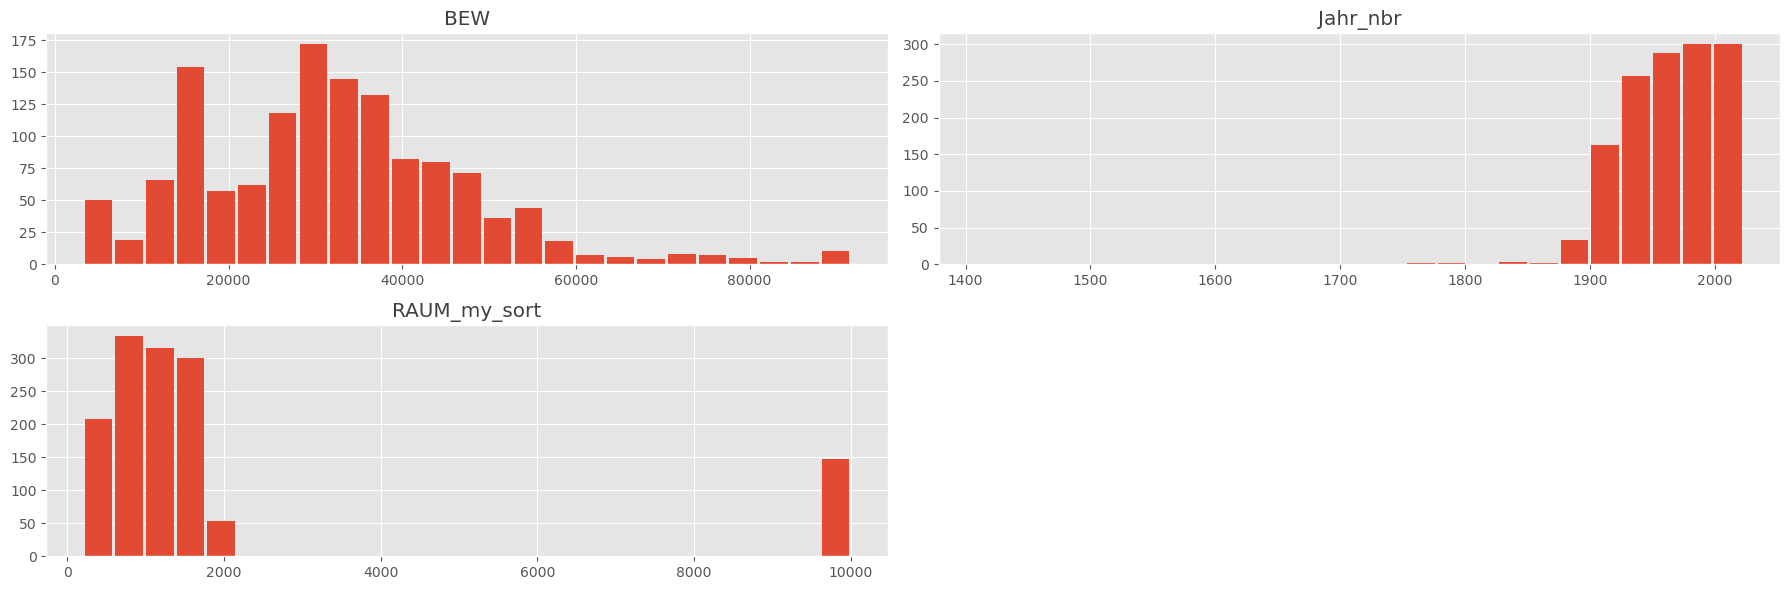

In [33]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [34]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,


### Nullwerte und Missings?

In [35]:
data2betested.isnull().sum()

ZEIT_lang              0
ZEIT_code              0
RAUM_lang              0
RAUM_code              0
BEW                    0
StichtagDatJahr_str    0
Jahr_nbr               0
RAUM_my_sort           0
dtype: int64

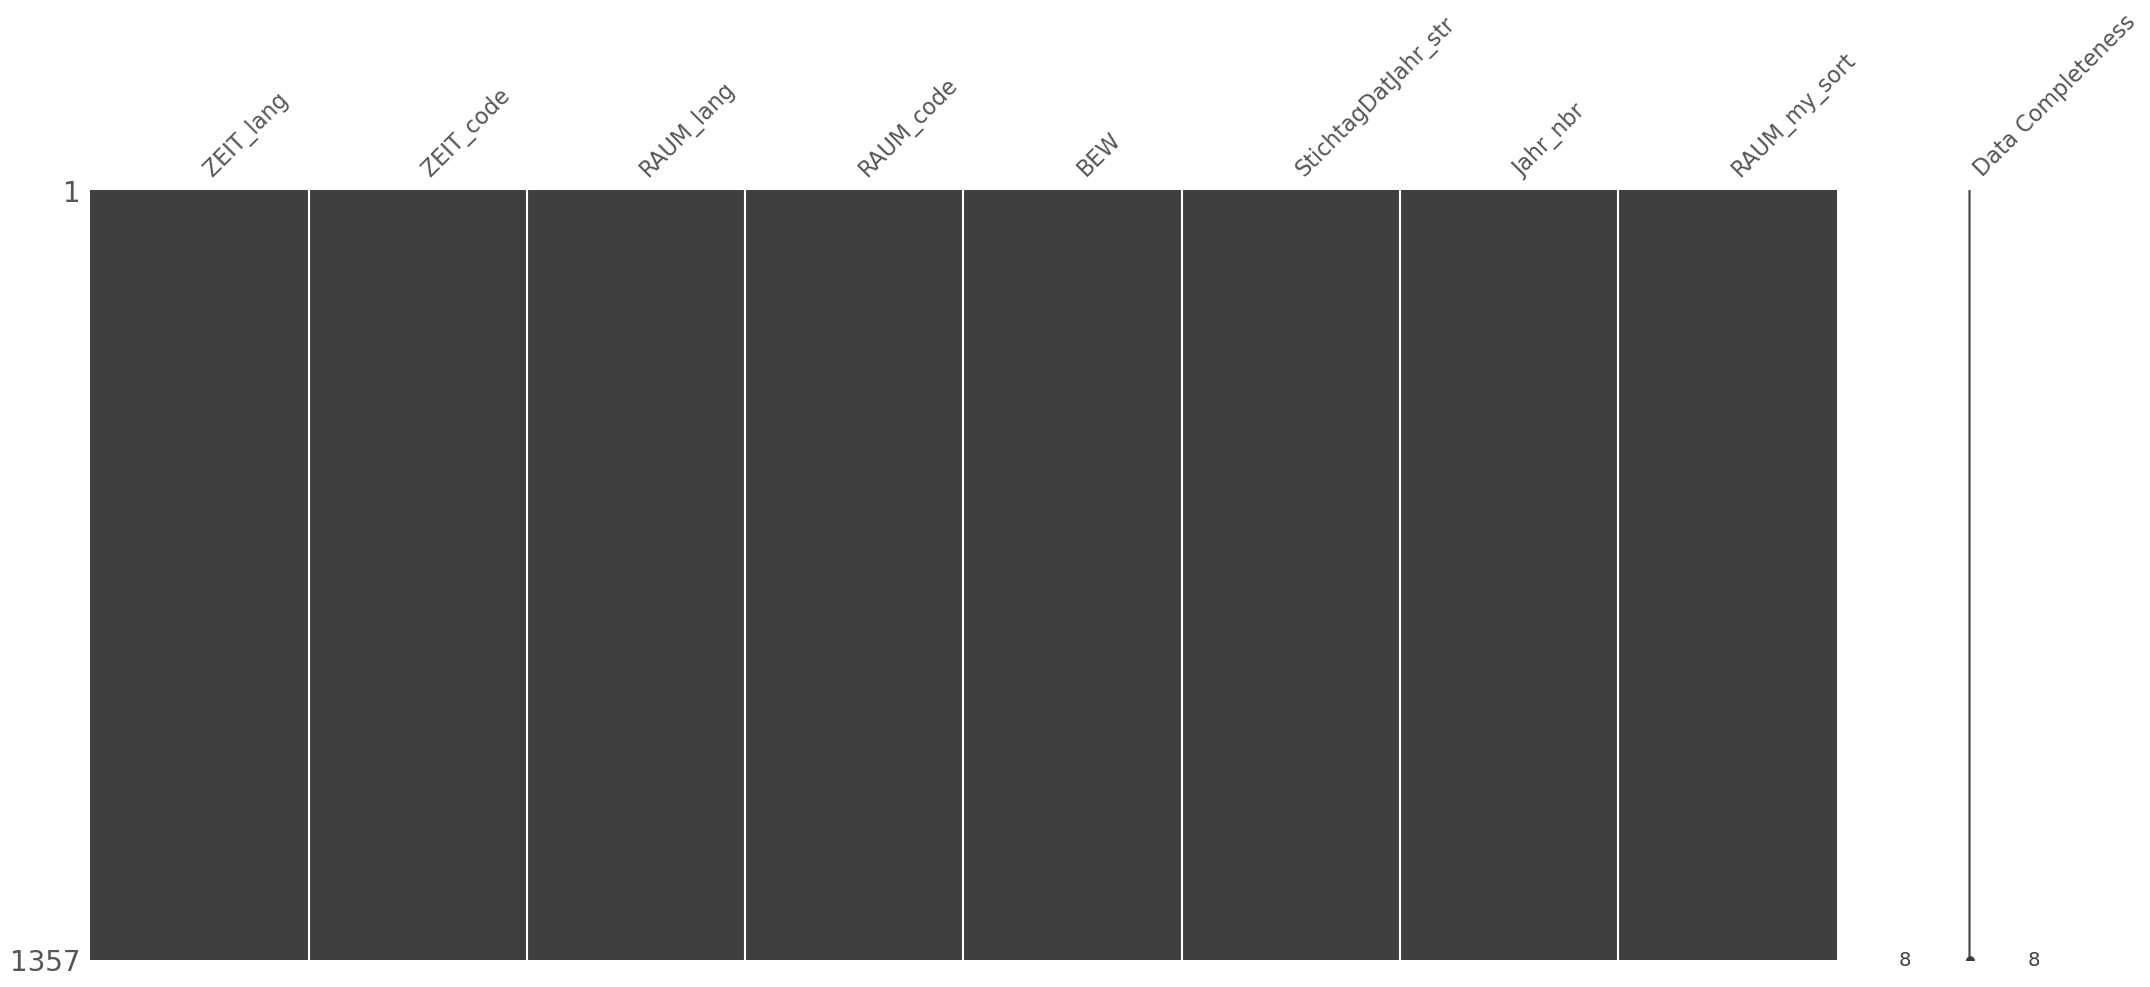

In [36]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [37]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr_nbr', ascending=False) 
agg_jahr.reset_index().head(3)

c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


,Jahr_nbr,sum_AnzBestWir
0,2023,447082
1,2022,443037
2,2021,436332


In [38]:
data2betested.RAUM_lang.unique()

array(['Kreis 1 (Stadtgebiet vor 1893)', 'Kreis 8 (ab 1915)',
       'alter Kreis 6 (1915-1933); alter Kreis IV (1893-1914)',
       'alter Kreis V (1893-1914)', 'Kreis 2 (ab 1893)',
       'Kreis III (1893-1914)', 'Kreis 3 (ab 1915)', 'Kreis 4 (ab 1915)',
       'alter Kreis 7 (1915-1933)', 'Kreis 5 (ab 1915)',
       'Kreis 9 (ab 1934)', 'Kreis 10 (ab 1934)', 'Kreis 6 (ab 1934)',
       'Kreis 7 (ab 1934)', 'alter Kreis 11 (1934-1969)',
       'altes Quartier Schwamendingen (1934-1969); Kreis 12 (ab 1970)',
       'Kreis 11 (ab 1970)'], dtype=object)

In [39]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','RAUM_lang', 'RAUM_code']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values(['Jahr_nbr','RAUM_code'], ascending=[False, True]) 
agg_Quarts.reset_index().head(50)

c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


,Jahr_nbr,RAUM_lang,RAUM_code,sum_AnzBestWir
0,2023,Kreis 2 (ab 1893),R00200,37639
1,2023,Kreis 3 (ab 1915),R00600,50950
2,2023,Kreis 4 (ab 1915),R00700,29944
3,2023,Kreis 5 (ab 1915),R00800,15874
4,2023,Kreis 8 (ab 1915),R01100,17860
5,2023,Kreis 6 (ab 1934),R01200,35688
6,2023,Kreis 7 (ab 1934),R01300,39647
7,2023,Kreis 9 (ab 1934),R01400,59841
8,2023,Kreis 10 (ab 1934),R01500,41411
9,2023,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,33537


In [40]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [41]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Kreis 7 (ab 1934),R01300,39647,2023-12-31,2023,1300
2023-12-31,2023-12-31,Z31122023,Kreis 6 (ab 1934),R01200,35688,2023-12-31,2023,1200


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [42]:
myAggAll = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAggAll.reset_index().head(30)

c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


,StichtagDatJahr,sum_WBev
0,2023-12-31,447082
1,2022-12-31,443037
2,2021-12-31,436332
3,2020-12-31,434736
4,2019-12-31,434008
5,2018-12-31,428737
6,2017-12-31,423310
7,2016-12-31,415682
8,2015-12-31,410404
9,2014-12-31,404783


In [43]:
myTitle="Bevölkerungsentwicklung, seit "+data_min_date

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_WBev'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggAll.reset_index().query('sum_WBev>30'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    #, color=alt.Color('QuarLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Stadtkreis seit ...

In [44]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [45]:
myAgg = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg.reset_index().head(3)

c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


,StichtagDatJahr,RAUM_lang,RAUM_code,sum_WBev
0,2023-12-31,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,33537
1,2023-12-31,Kreis 4 (ab 1915),R00700,29944
2,2023-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,5890


In [46]:

myTitle="Bevölkerung nach Stadtkreis, seit "+data_min_date

highlight = alt.selection(type='single', on='mouseover',
                          fields=['RAUM_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>0'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RAUM_lang', legend=alt.Legend(title="Stadtquartier", orient="right"), scale=alt.Scale(scheme='category20c'))  
    ,tooltip=['StichtagDatJahr', 'RAUM_lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Stadtkreis, 1890-1981

In [47]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg2 = data2betested.loc["1890":"1981"]\
    .groupby(['StichtagDatJahr', 'RAUM_code', 'RAUM_lang', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg2.reset_index().head(8)


c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


,StichtagDatJahr,RAUM_code,RAUM_lang,RAUM_my_sort,sum_WBev
0,1894-12-31,R00200,Kreis 2 (ab 1893),200,9407
1,1894-12-31,R00300,Kreis III (1893-1914),300,39177
2,1894-12-31,R00400,alter Kreis 6 (1915-1933); alter Kreis IV (189...,400,13764
3,1894-12-31,R00500,alter Kreis V (1893-1914),500,30610
4,1894-12-31,R01100,Kreis 8 (ab 1915),1100,14102
5,1894-12-31,R10000,Kreis 1 (Stadtgebiet vor 1893),10000,28099
6,1895-12-31,R00200,Kreis 2 (ab 1893),200,10645
7,1895-12-31,R00300,Kreis III (1893-1914),300,46857


In [48]:
myTitle="Entwicklung Wohnbevölkerung nach Stadtkreisen, 1890-1981"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['RAUM_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg2.reset_index().query('RAUM_my_sort > 100'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RAUM_lang', legend=alt.Legend(title="Stadtquartier", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'RAUM_lang','RAUM_my_sort','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [49]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2015":data_max_date]\
    .groupby(['StichtagDatJahr','Jahr_nbr', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


,StichtagDatJahr,Jahr_nbr,RAUM_lang,RAUM_code,sum_WBev
0,2015-12-31,2015,Kreis 1 (Stadtgebiet vor 1893),R10000,5617
1,2015-12-31,2015,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,31753
2,2015-12-31,2015,Kreis 9 (ab 1934),R01400,51328


In [50]:
#help(sns.catplot)     

In [51]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

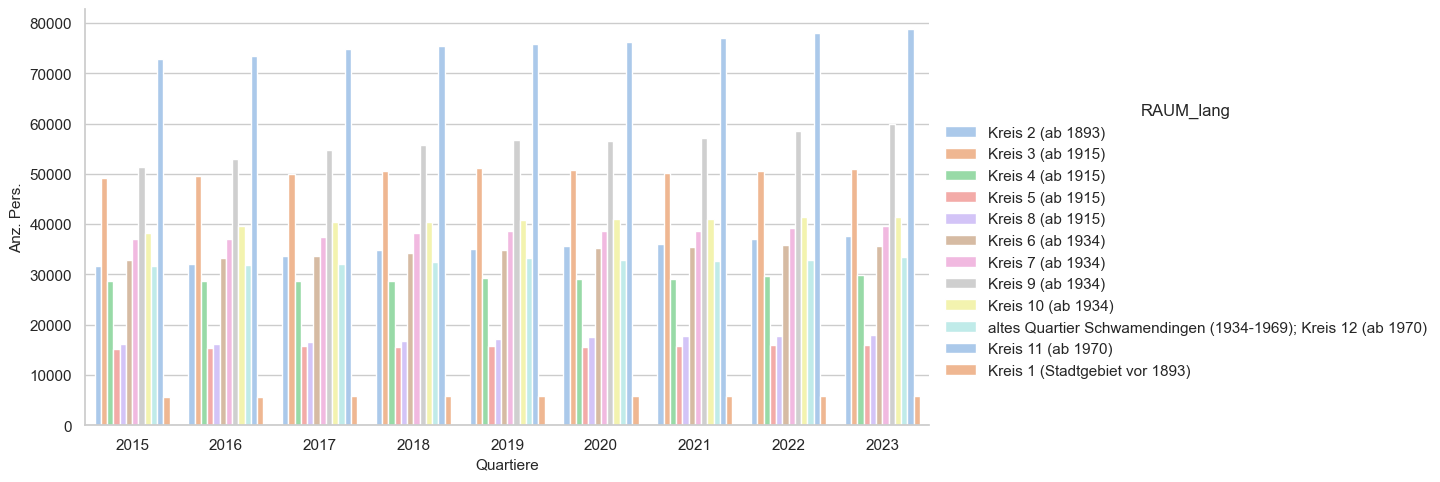

In [52]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_nbr"
            , y="sum_WBev"
            , hue="RAUM_lang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_code", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [53]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str',
       'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [54]:
myAggBar = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','StichtagDatJahr_str', 'RAUM_lang', 'RAUM_code', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myAggBar

c:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


,,,,,sum_WBev
Jahr_nbr,StichtagDatJahr_str,RAUM_lang,RAUM_code,RAUM_my_sort,
1928,1928-12-31,Kreis 2 (ab 1893),R00200,200,18972
1917,1917-12-31,Kreis 2 (ab 1893),R00200,200,17735
2014,2014-12-31,Kreis 2 (ab 1893),R00200,200,31156
2008,2008-12-31,Kreis 2 (ab 1893),R00200,200,29531
1974,1974-12-31,Kreis 2 (ab 1893),R00200,200,31706
...,...,...,...,...,...
1962,1962-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,10000,14025
1961,1961-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,10000,14139
2014,2014-12-31,Kreis 1 (Stadtgebiet vor 1893),R10000,10000,5616


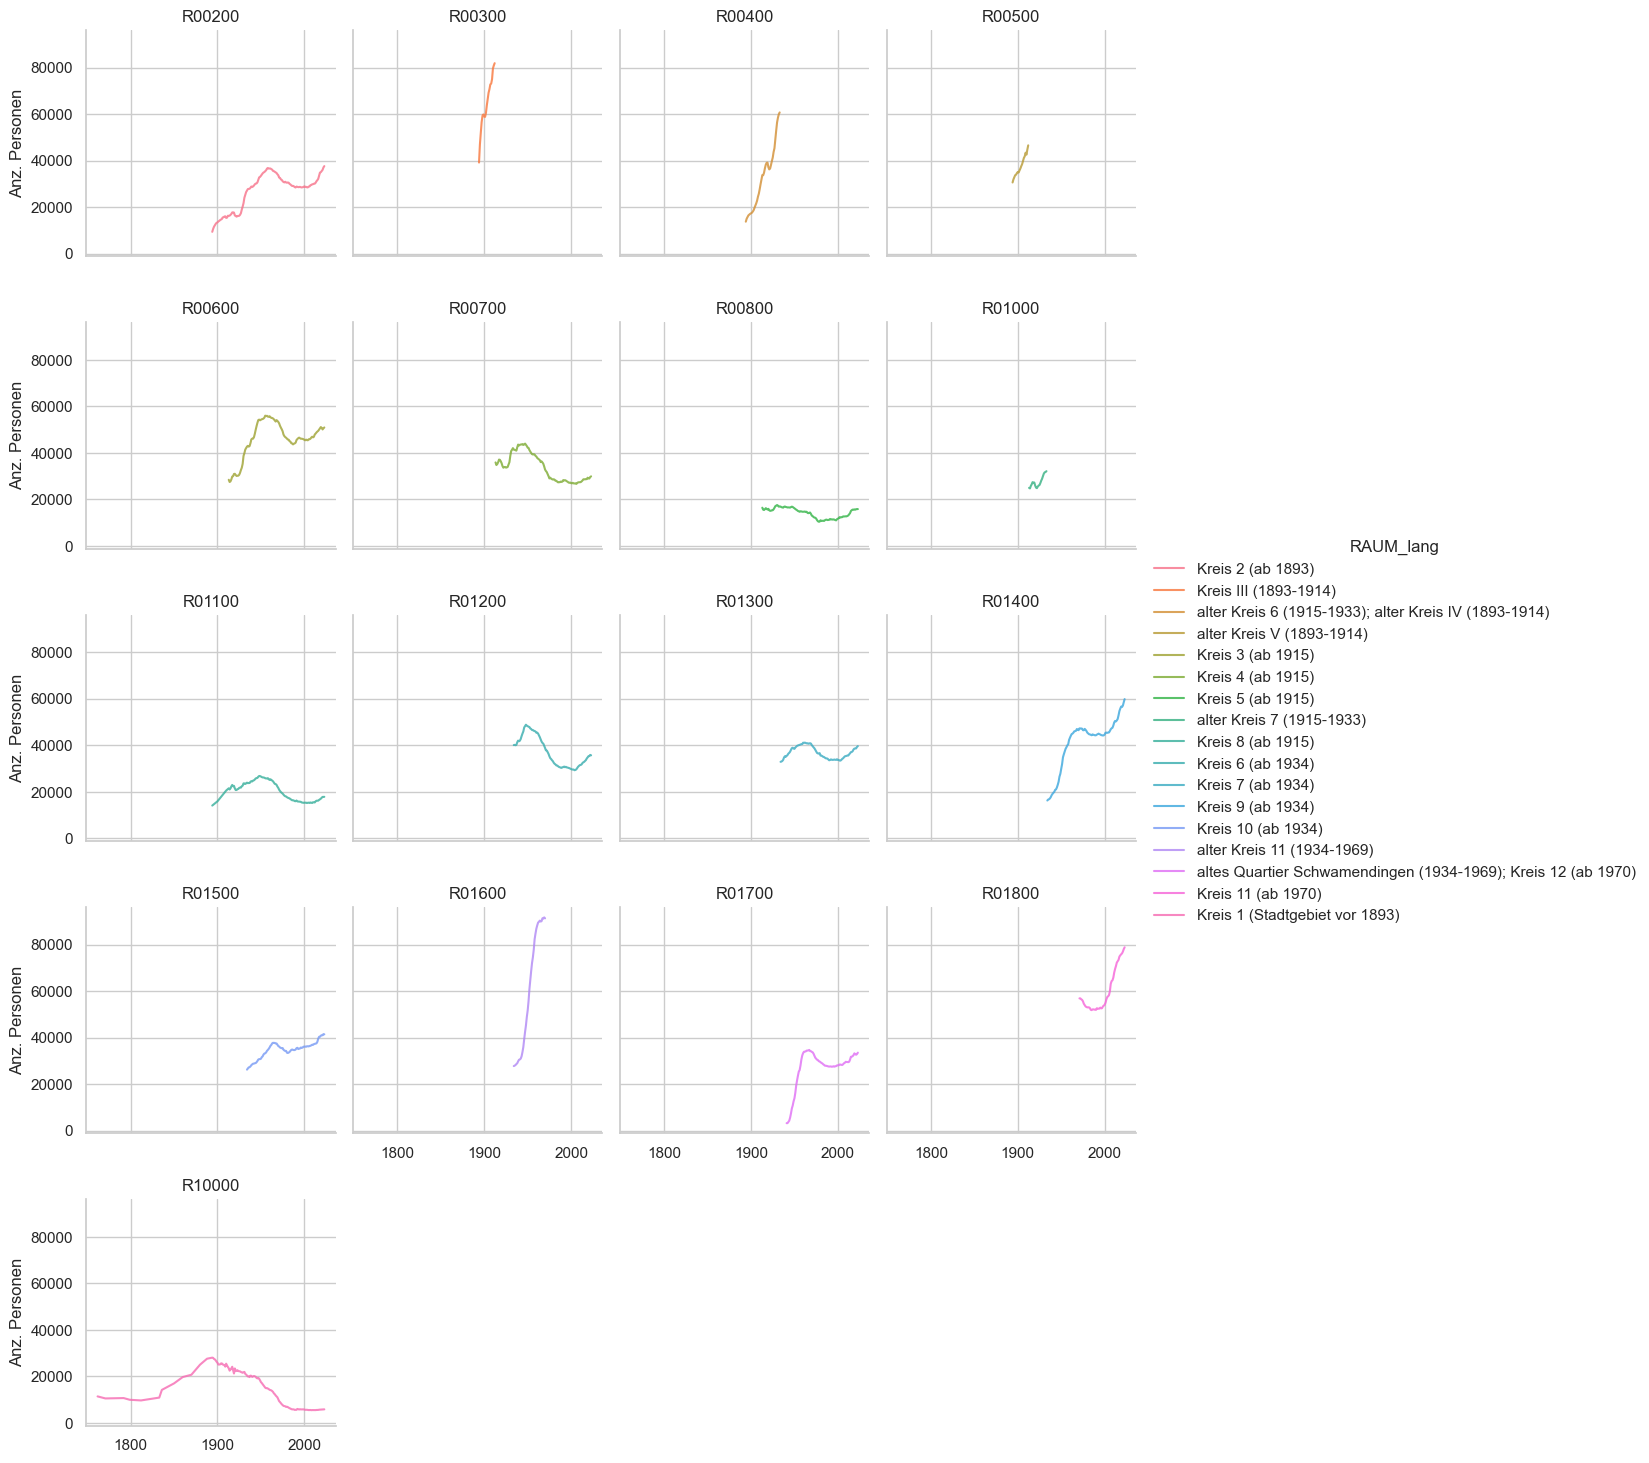

In [55]:
g2 = sns.FacetGrid(myAggBar.reset_index(), col="RAUM_code", hue="RAUM_lang", col_wrap=4, height=3,)
g2.map(sns.lineplot, "Jahr_nbr","sum_WBev",alpha=.8)

g2.set_axis_labels("","Anz. Personen")
g2.set_titles(col_template="{col_name}", row_template="{row_name}")

g2.add_legend()


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)